<h1 align="center" style="font-variant: small-caps">How to build a genome-scale self-replicating cell model</h1>
<h2 align="center">TUTORIAL 6 &mdash; Explore the self-replicating cell model</h2>
<h5 align="center">(<code>Version 16</code>, August 2025)</h5>

<div align="center" style="max-width:200px;display:block;margin:auto;">

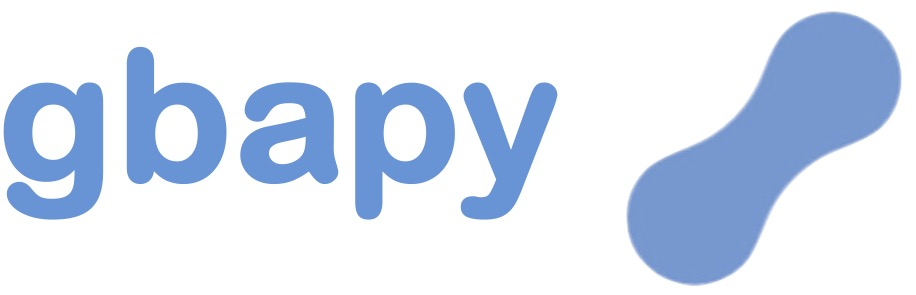

</div>

# Table of contents <a id="table_of_contents"></a>

- [1. Load the model builder](#load)
- [2. Create a function to automatically set up, build and test a model](#build)
- [3. Build the final model](#final_model)

# In summary

<div align="center" style="max-width:850px;display:block;margin:auto;">

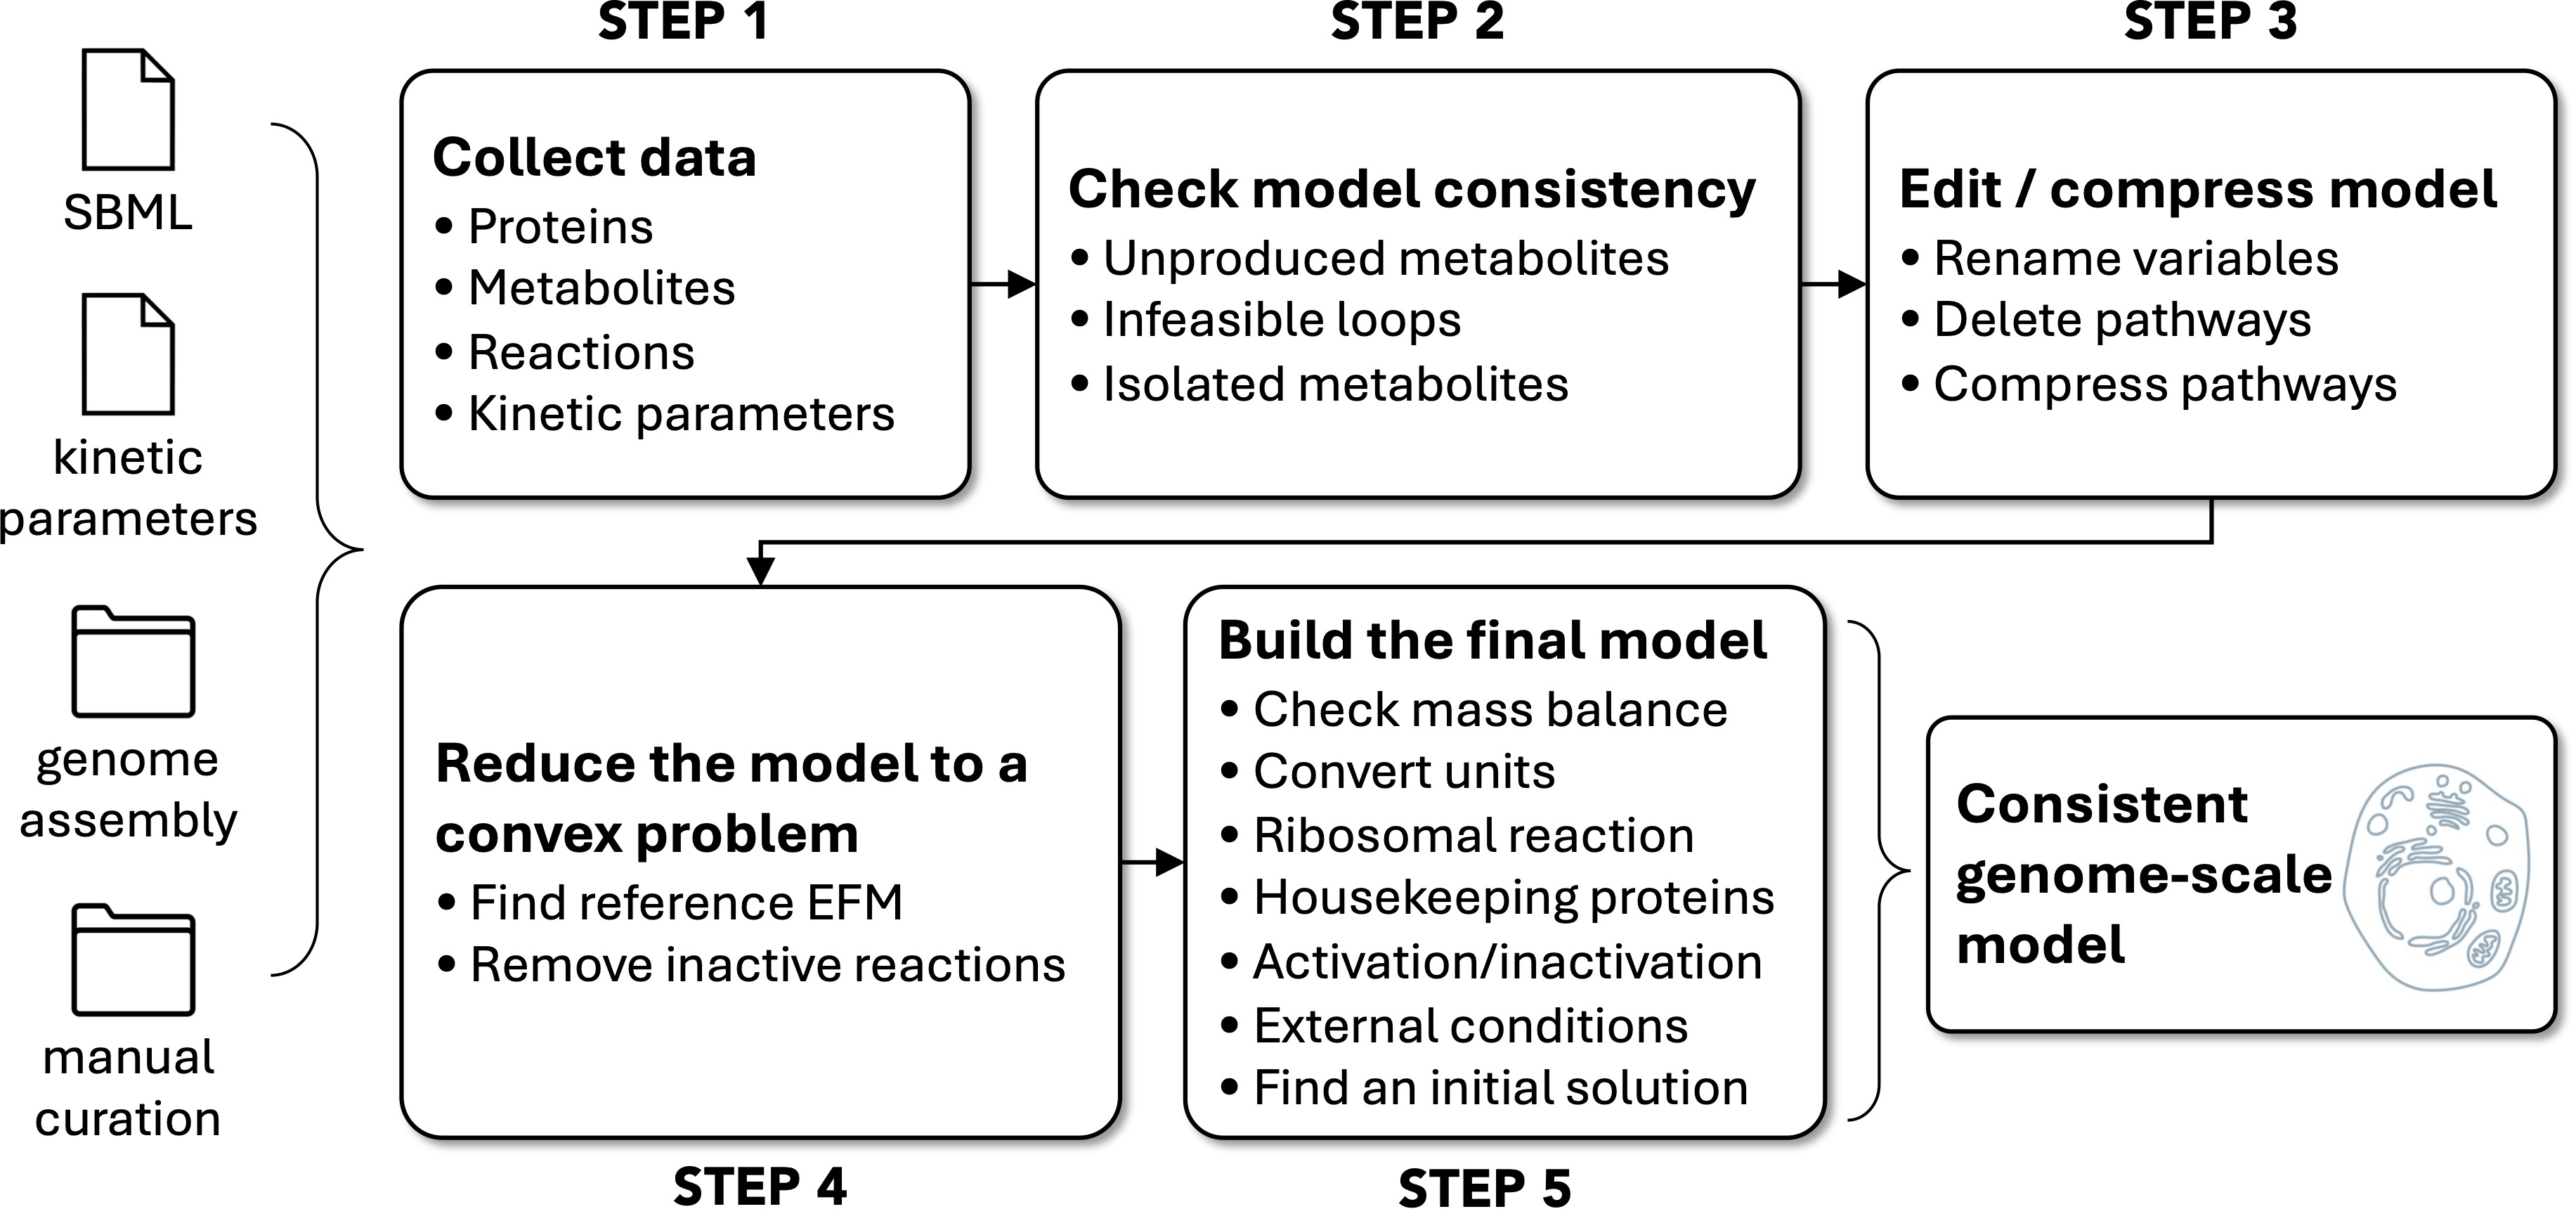

</div>

<div align="center">
<strong>At the beginning of each step of the tutorial, the GBApy methods used are listed</strong>.
</div>

This tutorial is made to facilitate the production of self-replicating cell models in order to test essential parameters such as the ribosome or ATP maintenance mass $k_\text{cat}$ values. Each time a parameter is modified and a new version of the model is produced, it can be optimized with <strong>gbacpp</strong>.

# 2. Load the model builder <a id="load"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.load_builder( path )</code> | Load a model builder from a backup |

</div>

The CGM builder is loaded from the backup created in tutorial 5.
We also re-load the original SBML model of a minimal cell.

In [1]:
import gba
import cobra
import numpy as np

builder    = gba.load_builder("backup/mmsyn_build_5.gbabuild")
sbml_model = cobra.io.read_sbml_model("data/manual_curation/MMSYN_annotated.xml")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-15
Read LP format model from file /var/folders/5h/n0xqh1xj2zg6yyd747k95bc80000gn/T/tmpyctxe4ty.lp
Reading time = 0.00 seconds
: 138 rows, 286 columns, 1216 nonzeros


# 2. Create a function to automatically set up, build and test a model <a id="build"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.check_model( test_structure )</code> | Test the consistency of the model build |
| <code>gba.Builder.adjust_masses( metabolites )</code> | Adjust masses from a list of positive or negative corrections |
| <code>gba.Builder.check_mass_balance( verbose )</code> | Check the mass balance of each reaction of the model |
| <code>gba.Builder.convert( ribosome_byproducts )</code> | Convert all model units to GBA units |
| <code>gba.Builder.build_GBA_model()</code> | Build the GBA converted model |
| <code>gba.Builder.clear_conditions()</code> | Delete all the external conditions of the model |
| <code>gba.Builder.add_condition( condition_id, rho, default_concentration, metabolites )</code> | Add an external condition to the model |
| <code>gba.Builder.add_activation_constant( metabolite_id, reaction_id, value )</code> | Add an activator metabolite to a reaction |
| <code>gba.Builder.add_constant_rhs( metabolite_id, value )</code> | Add a constant RHS term for the initial solution |
| <code>gba.Builder.clear_constant_reactions()</code> | Remove the list of constant reactions |
| <code>gba.Builder.enforce_directionality( flux_vector )</code> | Enforce the directionality of the model given a flux vector |
| <code>gba.Builder.export_model( path )</code> | Export the model in CSV format |
| <code>gba.read_csv_model( name, path )</code> | Load a model (class Model) from CSV files |
| <code>gba.Model.generate_LP_initial_solution( max_flux_fraction, rhs_factor, save_f0) </code> | Generate and test an initial solution to the model using a LP routine |

</div>

First, we create a function to automatically set up model properties (activators, constant fluxes, etc), build it, and find an initial solution.

This function will also print the column rank of the internal $M$ matrix, and if this matrix is full column rank.

In [2]:
def model_pipeline( builder, sbml_model, model_name,
                  max_flux_fraction, rhs_factor, condition, rho,
                  ribosome_mass_kcat, ribosome_mass_km, atpase_kcat,
                  add_activation, add_regulation ):
    builder.check_model(test_structure=True)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 1) Adjust metabolite masses               #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    mass_adjustement                 = {}
    mass_adjustement["x_AA"]         = 17.007345999998506
    mass_adjustement["AA"]           = 17.007345999998506
    mass_adjustement["tRNA"]         = -94.58300315200177
    mass_adjustement["AAtRNA"]       = -94.58300315200177
    mass_adjustement["apoACP"]       = 1752.813
    mass_adjustement["ACP"]          = 1752.813
    mass_adjustement["ACP_R"]        = 1329.707
    mass_adjustement["dUTPase"]      = 2600.639
    mass_adjustement["PdhC"]         = 12940.79
    mass_adjustement["lpl_PdhC"]     = 12934.08
    mass_adjustement["acdhlpl_PdhC"] = 12934.08
    mass_adjustement["dhlpl_PdhC"]   = 12934.08
    mass_adjustement["Protein"]      = 8932.936
    mass_adjustement["x_5fthf"]      = 292.2431019999999
    mass_adjustement["5fthf"]        = 292.2431019999999
    mass_adjustement["lgltn"]        = 7.5569999999988795
    mass_adjustement["cdpdag"]       = 0.13765799800012246
    mass_adjustement["dnad"]         = 0.31494099599990477
    mass_adjustement["thfglu3"]      = 30.026026999999885
    mass_adjustement["fmettrna"]     = -667.2529067019968
    mass_adjustement["galfur12dgr"]  = -13.324124999999867
    gba.throw_message(gba.MessageType.Plain, "Adjusting masses")
    builder.adjust_masses(mass_adjustement)
    builder.check_mass_balance(verbose=True)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 2) Convert to GBA units                   #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    builder.convert(ribosome_mass_kcat=ribosome_mass_kcat, ribosome_mass_km=ribosome_mass_km)
    if atpase_kcat is not None:
        gba.throw_message(gba.MessageType.Plain, "Setting the housekeeping ATPase reaction")
        builder.reactions["ATPase"].GBA_kcat[gba.ReactionDirection.Backward] = atpase_kcat
    builder.build_GBA_model()
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 3) Show the column rank of the matrix     #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    x1 = builder.GBA_column_rank
    x2 = builder.GBA_intM.shape[1]
    gba.throw_message(gba.MessageType.Plain, "Column rank {}/{} ( diff = {})".format(x1, x2, x2-x1))
    if builder.GBA_is_full_column_rank:
        gba.throw_message(gba.MessageType.Info, "Matrix is full column rank")
    gba.throw_message(gba.MessageType.Plain, "Dependent reactions:"+str(builder.GBA_dependent_reactions))
    gba.throw_message(gba.MessageType.Plain, "internal M shape:"+str(builder.GBA_intM.shape))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 4) Add conditions                         #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # (1) Load the medium composition from Thrornburg et al. (2022)
    f           = open("./data/Thornburg-et-al-2022/simulation_medium.csv", "r")
    l           = f.readline()
    l           = f.readline()
    metabolites = {}
    while l:
        l    = l.strip("\n").split(";")
        m_id = l[1]
        conc = float(l[4])
        if m_id in builder.metabolites:
            metabolites[m_id] = conc*0.001*builder.metabolites[m_id].mass
        l = f.readline()
    f.close()
    # (2) Complete the medium composition
    metabolites["x_h2o"] = 1000.0
    metabolites["x_h"]   = 1e-7
    # (3) Create external conditions with an external glucose gradient
    glucose_gradient = 10.0**np.arange(-5.9, 1.1, 0.1)
    index            = 1
    builder.clear_conditions()
    for i in range(len(glucose_gradient)):
        metabolites["x_glc__D"] = glucose_gradient[i]
        builder.add_condition(condition_id=index, rho=rho, default_concentration=1.0, metabolites=metabolites)
        index += 1
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 5) Activator metabolites                  #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    if add_activation:
        gba.throw_message(gba.MessageType.Plain, "Adding activators")
        DNA = 5.5/100.0
        RNA = 16.274/100.0
        builder.add_activation_constant("DNA", "DNAP", rho*DNA)
        builder.add_activation_constant("DNA", "RNAP", rho*DNA)
        builder.add_activation_constant("DNA", "tRNAP", rho*DNA)
        builder.add_activation_constant("RNA", "Ribosome", rho*RNA)
        builder.add_constant_rhs("DNA", DNA)
        builder.add_constant_rhs("RNA", RNA)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 6) Regulator metabolites                  #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    if add_regulation:
        gba.throw_message(gba.MessageType.Plain, "Adding regulators")
        f = open("./data/manual_curation/MMSYN_regulators.csv", "r")
        l = f.readline()
        l = f.readline()
        while l:
            if not l.startswith("#"):
                l = l.strip("\n").split(";")
                m_id = l[0]
                r_id = l[1]
                frac = float(l[2])*0.01
                if m_id in builder.metabolites and r_id in builder.reactions:
                    gba.throw_message(gba.MessageType.Plain, f"Adding {m_id} regulation on {r_id} (b={frac})")
                    builder.add_regulation_constant(m_id, r_id, rho*frac)
                    builder.add_constant_rhs(m_id, frac)
            l = f.readline()
        f.close()
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 7) Enforce directionality                 #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    builder.enforce_directionality(builder.FBA_solution.fluxes)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 8) Create the CGM                         #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    #builder.summary()
    builder.write_to_csv("./models", name=model_name) 
    model = gba.read_csv_model(name=model_name, path="./models")
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 9) Find an initial solution               #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    model.find_initial_solution(condition_id=condition, max_flux_fraction=max_flux_fraction, rhs_factor=rhs_factor)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 10) Return the model                      #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    return model

# 3. Build the final model <a id="cgm"></a>

[&#10148; Back to the table of contents](#table_of_contents)

We now use our function `model_pipeline()` written above to produce the self-replicating cell model. The model will be saved into `./tutorials/MMSYN_tutorials/models/.`, and can be later optimized with <strong>gbacpp</strong>.

In [3]:
model = model_pipeline(builder=builder, sbml_model=sbml_model, model_name="mmsyn_v2",
                       max_flux_fraction=40.0, rhs_factor=10.0, condition="67", rho=349,
                       ribosome_mass_kcat=16, ribosome_mass_km=None, atpase_kcat=1.11,
                       add_activation=True, add_regulation=False)

# 0.5001 : ribosome_mass_kcat=16, atpase_kcat=1.11, mu=0.36 (activation/no regulation)

❯ Info,No missing mass in the model.


❯ Info,No missing kinetic parameters in the model.


❯ Info,No connectivity issues in the model.


❯ Info,No unproduced metabolites in the model.


❯ Info,No infeasible loops in the model.


❯ Info,No isolated metabolites in the model.


❯,Adjusting masses


❯ Info,Model build JCVI-syn3A is mass balanced.


❯,Setting the housekeeping ATPase reaction


❯,Column rank 112/115 ( diff = 3)


❯,"Dependent reactions:['TKT2', 'TPI']"


❯,"internal M shape:(112, 115)"


❯,Adding activators


❯ Info,Model is consistent with mu = 0.12085520526523602.


In [4]:
builder.summary()
model.summary()

Model build JCVI-syn3A summary General 
 
 
 Category 
 Count 
 
 
 
 
 Known proteins 
 461 
 
 
 Modeled proteins 
 174 
 
 
 Metabolites 
 137 
 
 
 Reactions 
 115 
 
 
 Metabolites 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Small molecules 
 114 
 83.21% 
 
 
 Macro-molecules 
 19 
 13.87% 
 
 
 DNA(s) 
 1 
 0.73% 
 
 
 RNA(s) 
 3 
 2.19% 
 
 
 Proteins 
 0 
 0.00% 
 
 
 Unknown 
 0 
 0.00% 
 
 
 Reaction types 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Metabolic 
 90 
 78.26% 
 
 
 Transport 
 15 
 13.04% 
 
 
 Spontaneous 
 10 
 8.70% 
 
 
 Exchange 
 0 
 0.00% 
 
 
 Reaction directions 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Forward 
 65 
 56.52% 
 
 
 Backward 
 1 
 0.87% 
 
 
 Reversible 
 49 
 42.61%

Category,Count
Nb metabolites,137
Nb external metabolites,24
Nb internal metabolites,113
Category,Count
Nb reactions,115
Nb exchange reactions,87
Nb internal reactions,27
Category,Count
Column rank,113
Is full column rank?,False


In [5]:
model.write_to_csv("./models", name="mmsyn_v2")
model.write_to_ods("./models", name="mmsyn_v2")